## Analyze A/B Test Results of two landing page


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)


a. Read in the dataset and take a look at the top few rows here:

In [4]:
df=pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df["user_id"].nunique()

290584

d. The proportion of users converted.

In [7]:
df["converted"].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
#first: group = treatment and landing page = old page
first=df.query("group=='treatment'and landing_page != 'new_page'")
#second: group = control and landing page= new page
second=df.query("group!='treatment'and landing_page == 'new_page'")
total_times=first.count()[0]+second.count()[0] #sum of first and second
total_times

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum() # no missing values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64



a. create a new dataset, Store your new dataframe in **df2**.

In [10]:
df2=df.drop(first.index) #drop the rows when group = treatment and landing page = old page 
df2=df2.drop(second.index)#drop the rows when group = control and landing page= new page


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [12]:
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2["user_id"].duplicated()]["user_id"]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
user_duplic= df2[df2["user_id"].duplicated()]
user_duplic

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2=df2.drop(user_duplic.index)

In [16]:
df2["user_id"].duplicated().sum() #check

0

`4.`

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2["converted"].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
prob_control_conv=df2.query("group =='control' ")["converted"].mean()
prob_control_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
prob_treat_conv=df2.query("group =='treatment' ")["converted"].mean()
prob_treat_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
(df2["landing_page"]=="new_page").mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [21]:
#differance of the two percentage probabilities (treatment who converted and control who converted )
diffs=prob_control_conv-prob_treat_conv
diffs

0.0015782389853555567


**the difference  of the two percentage probabilities of the treatment who converted and control who converted is  0.15% and that a small difference so there is not sufficient evidence to suggest that the new treatment page leads to more conversions**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


**H0: P_old - P_new ≥ 0     or (P_old ≥ P_new)**
 
**H1: P_old - P_new < 0     or (P_old < P_new)**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
p_new = (df2['converted'] == 1).mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df2[df2["group"]=="treatment"].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2[df2["group"]=="control"].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice(2,n_new,replace = True,p=[(1-p_new),p_new])
new_page_converted.mean()

0.12106530865047141

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted =np.random.choice(2,n_new,replace = True,p=[(1-p_old),p_old])
old_page_converted.mean()

0.1180441814052715

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0030211272451999144

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs=[]
for i in range(10000):
    old_page_converted =np.random.choice(2,n_new,replace = True,p=[(1-p_old),p_old])
    new_page_converted = np.random.choice(2,n_new,replace = True,p=[(1-p_new),p_new])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

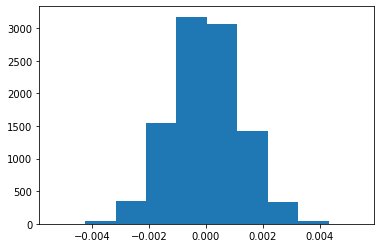

In [30]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs);

In [31]:
#differance of the two percentage probabilities (treatment who converted and control who converted )
obs_diff =  prob_control_conv - prob_treat_conv
obs_diff

0.0015782389853555567

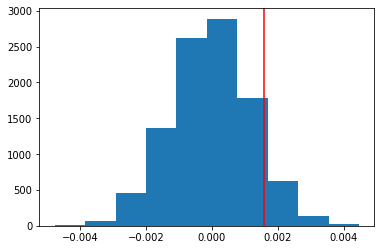

In [32]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# Plot the null distribution
plt.hist(null_vals);
# Plot observed statistic with the null distibution
plt.axvline(obs_diff, c='red')

**because the alternate hypothesis talks about "less than 0" (with the tail of the sign pointing to the left), the area that we are going to calculate is everything shaded aqua that is to the left of the red line, or the proportion of values from our null distribution that are less than the observed mean.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
(p_diffs < obs_diff).mean()

0.9042

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This p-value and it mean the probability of obtaining the observed statistic or a "more extreme" value (by extreme we just mean more in favour of the alternate hypothesis mean) if the null hypothesis is true and The p-value helps us make a decision. Because of the way we construct our assumptions, when calculated, the p-value tells us the probability of committing a Type I error if the null hypothesis is true. so  here This p-value is higher than  α level(Type I error)= 0.05 and so in this case we would fail to reject the null hypothesis and choosen the old page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [35]:
import statsmodels.api as sm

convert_old = df2.query("group=='control'   and converted ==1 " ).shape[0]
convert_new = df2.query("group=='treatment' and converted ==1 " ).shape[0]
n_old = df2[df2["group"]==  "control"].shape[0]
n_new = df2[df2["group"]=="treatment"].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [36]:
from statsmodels.stats.proportion import proportions_ztest

count=np.array([convert_old , convert_new])
nobs =np.array([n_old, n_new])
zstat , p_value = proportions_ztest(count, nobs, alternative = 'smaller')
zstat, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?


**Z scores are measures of standard deviation P-values are probabilities. Both statistics are associated with the standard normal distribution ,the critical Z score values when using a 95% confidence level are -1.96 and +1.96 standard deviations. The p-value associated with a 95% confidence level is 0.05. If your Z score is between -1.96 and +1.96, your p-value will be larger than 0.05, and you cannot reject your null hypothsis and choosen the old page ,yes it agree with the findings in parts j and k**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?


**a logistic regression should be performed in this case as we are looking at binary variables conversion =1 and no conversion =0**
 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept'] = 1
df2[['ab_page1' , 'ab_page']] = pd.get_dummies(df['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page1,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
model = sm.Logit(df2["converted"] , df2[['intercept' , 'ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
print(result.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-10-04 23:10 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074



e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

In [40]:
np.exp(result.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [41]:
1/np.exp(result.params)

intercept    7.306593
ab_page      1.015102
dtype: float64


**associated with ab_page the  p-value = 0.1899**
**,here p-value is Not statistically significant in relating to the response variable and These p-values differ from Part II because in the A/B test our null hypothesis states that the old page is better
than, or equal to, the new (a one-tailed test). Regression is a two-tailed test therefore p-values have a different
meaning relating to slope.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


**when  the relation  not linearly related, higher order terms (such as interactions, quadratics, and
cubics) might be considered.For example, if the slopes of two x variables are not parallel, this indicates that an
interaction between those two variables is likely present. In this case, we can create a new column that
multiplies these two values and review this added interaction with the predictor (y) variable.**

**and the collinearity is one of  disadvantages and adding these terms make the interpreting complicated**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 



In [42]:
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
df3["country"].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [44]:
df3 = df3.join(pd.get_dummies(df3.country))

In [45]:
df2 = df2.join(df3.set_index('user_id') , on = 'user_id')

In [46]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page1,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [47]:
model2 = sm.Logit(df2["converted"] , df2[['intercept', 'ab_page', 'UK', 'US']])
results = model2.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-10-04 23:10 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912

In [48]:
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [49]:
1/np.exp(results.params)

intercept    7.614303
ab_page      1.015056
UK           0.950621
US           0.960062
dtype: float64

**we can say that UK is 1.05 times likely to convert to new page than the CA holding all else constant**


**we can say that US is 1.04 times likely to convert to new page than the CA holding all else constant**


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [50]:
df2['ab_uk'] = df2["ab_page"]  * df2["UK"]
df2['ab_us'] = df2["ab_page"]  * df2["US"]

In [51]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page1,ab_page,country,CA,UK,US,ab_uk,ab_us
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0


In [52]:
fin_model = sm.Logit(df2["converted"] , df2[['intercept', 'ab_page', 'UK', 'US' , 'ab_uk' , 'ab_us']])
fin_result = fin_model.fit()
print(fin_result.summary2())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-10-04 23:10 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947

In [53]:
np.exp(fin_result.params)

intercept    0.134794
ab_page      0.934776
UK           1.011854
US           1.017682
ab_uk        1.081428
ab_us        1.048001
dtype: float64

In [54]:
1/np.exp(fin_result.params)

intercept    7.418713
ab_page      1.069775
UK           0.988285
US           0.982625
ab_uk        0.924703
ab_us        0.954198
dtype: float64

## conclusions


**we can say that UK is 1.01 times likely to convert to new page than the CA holding all else constant**


**we can say that US is 1.017 times likely to convert to new page than the CA holding all else constant**

**but ab_uk and ab_us are different because there is a relation between ap page and the country**

**so we can say that the person in UK and with old page are 1.08 more likely to convert than one from the CA with old page holding all else constant**

**and we can say that the person in US and with old page are 1.048 more likely to convert than one from the CA with old page holding all else constant**
